## PyTorch Geometric Tutorial


In [1]:
import networkx as nx                          
import numpy as np                             
import matplotlib.pyplot as plt                
import torch 
%matplotlib inline
print(torch.__version__)
print(torch.version.cuda)

1.11.0
11.3


### Karate club Network
- This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.
- 가라테 동아리의 34명의 회원과, 동아리 밖에서의 교류한 회원들의 연결을 표현. 구성원의 상호작용에서 발생하는 커뮤니티(4개의 클래스)를 탐지하는데 관심이 있음


In [2]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [3]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                         node_color=color, cmap="Set2")
    plt.show()

In [4]:
print(type(dataset))
print(dataset[0])

<class 'torch_geometric.datasets.karate.KarateClub'>
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [5]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


- COO format (coordinate format)
    - 희소행렬을 표현하기 위한 방안. 
    - 인접행렬 $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$로 표현하는 것이 아니라, 행렬 A에서 0이 아닌 좌표/값만을 사용함

In [6]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

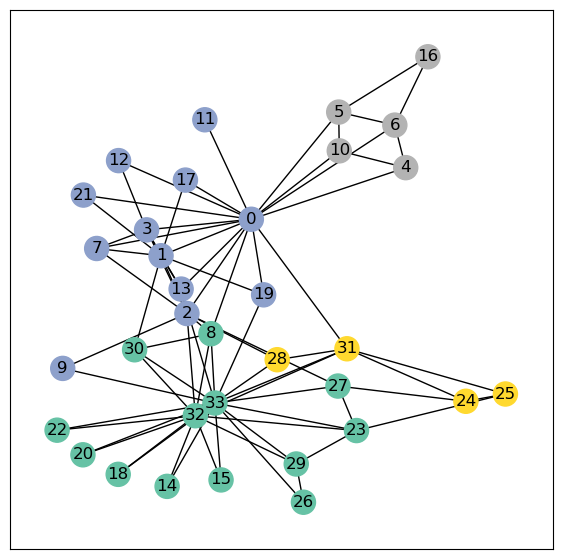

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


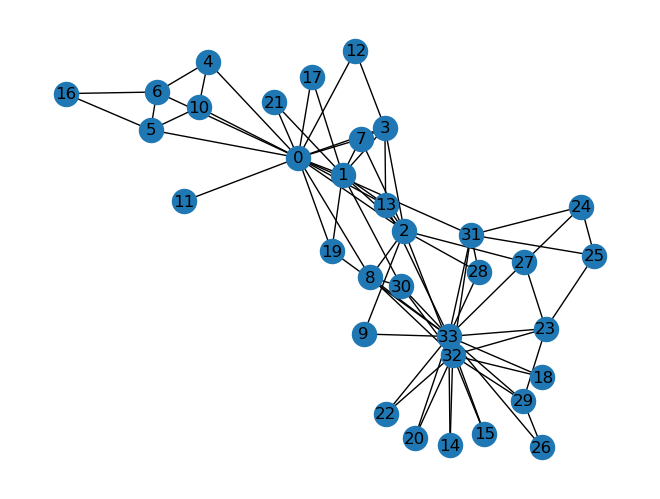

In [7]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)
print(data.y)

nx.draw(G, with_labels = True)

## GCN

- GNN의 가장 기본적인 연산인 GCN layer를 사용하자.
    - Kipf et al. (2017) https://arxiv.org/abs/1609.02907)
    - GCN layer는 PyG에서 `GCNConv`로 구현되어 있으며, 노드의 표현 `x`와 그래프의 COO 표현의 연결성을 입력으로 받는다.
        - https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv))
    - 

- 아래 모델은 3개의 GCN layer로 구성되어 있는데, 이는 각 노드마다 3-hop 이웃의 정보를 집계하는 것을 의미
    - GCN layer는 각 노드의 표현을 $34 \to 4 \to 4 \to 2$이 되게 한다.
- 각 GCN layer 이 후에는 tanh 활성함수를 통과하며, 최종적으로 우리가 원하는 클래스(커뮤니티 4개)로 하는 분류기를 학습
- 모델은 (GCN의 표현, 분류기의 결과) 출력


## PyG - GCNConv

- 논문에서의 graph convolutinal operator $$\mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},$$
    - where,
        - $\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$: self-loop을 더한 인접행렬
        - $\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}$


- 이를, node-wise formula로 바꾸면, 
$$\mathbf{x}^{\prime}_i = \mathbf{\Theta}^{\top} \sum_{j \in
\mathcal{N}(v) \cup \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j
\hat{d}_i}} \mathbf{x}_j$$
    - where, 
        - $\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}$
        - $e_{j,i}$: j에서 i로 향하는 edge weight

- parameters
    - `in_channels` (int) – Size of each input sample, or -1 to derive the size from the first input(s) to the forward method.
    - `out_channels` (int) – Size of each output sample.
    - `improved` (bool, optional) – If set to True, the layer computes $\mathbf{\hat{A}}$ as $\mathbf{A} + 2\mathbf{I}$ . (default: False)
    - `cached` (bool, optional) – If set to True, the layer will cache the computation of $\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}} \mathbf{\hat{D}}^{-1/2}$ on first execution, and will use the cached version for further executions. This parameter should only be set to True in transductive learning scenarios. (default: False)
    - `add_self_loops` (bool, optional) – If set to False, will not add self-loops to the input graph. (default: True)
    - `normalize` (bool, optional) – Whether to add self-loops and compute symmetric normalization coefficients on the fly. (default: True)
    - `bias` (bool, optional) – If set to False, the layer will not learn an additive bias. (default: True)
    - `**kwargs` (optional) – Additional arguments of torch_geometric.nn.conv.MessagePassing.




- <img  src="./img/GCN1.png" width="70%">

In [8]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [9]:
print(data.num_features)
for i in range(data.num_features):
    print(list(map(int, (data.x[i].tolist()))))

34
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
data.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

- 학습하기 전의 2차원으로 표현한 임베딩 값을 확인하더라도, 노드의 클래스(커뮤니티)끼리 유사한 공간에 존재하는 것 확인
- 이는 GNN의 **Inductive Bias** 자체가 강력하다는 것을 의미 

Embedding shape: [34, 2]


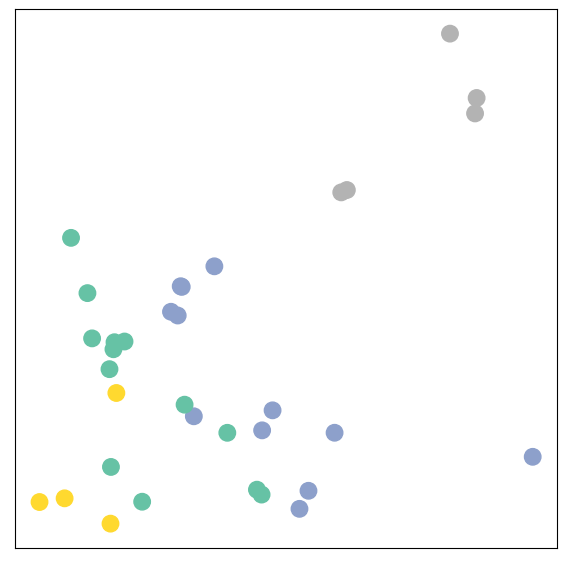

In [11]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

In [12]:
print(data.train_mask)
print(data.y)
print(data.y[data.train_mask])

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
tensor([1, 3, 0, 2])


- 여기서 모델의 파라미터를 학습(손실함수에 반영하는) 사용하는 노드는 `train_mas` 4가지 

epoch: 0	f1: 0.045	acc: 0.100	
epoch: 10	f1: 0.056	acc: 0.100	
epoch: 20	f1: 0.158	acc: 0.200	
epoch: 30	f1: 0.204	acc: 0.233	
epoch: 40	f1: 0.386	acc: 0.567	
epoch: 50	f1: 0.345	acc: 0.367	
epoch: 60	f1: 0.292	acc: 0.300	
epoch: 70	f1: 0.315	acc: 0.333	
epoch: 80	f1: 0.290	acc: 0.300	
epoch: 90	f1: 0.235	acc: 0.267	
epoch: 100	f1: 0.290	acc: 0.300	
epoch: 110	f1: 0.235	acc: 0.267	
epoch: 120	f1: 0.235	acc: 0.267	
epoch: 130	f1: 0.235	acc: 0.267	
epoch: 140	f1: 0.194	acc: 0.233	
epoch: 150	f1: 0.275	acc: 0.300	
epoch: 160	f1: 0.275	acc: 0.300	
epoch: 170	f1: 0.275	acc: 0.300	
epoch: 180	f1: 0.275	acc: 0.300	
epoch: 190	f1: 0.310	acc: 0.333	
epoch: 200	f1: 0.524	acc: 0.533	
epoch: 210	f1: 0.462	acc: 0.600	
epoch: 220	f1: 0.524	acc: 0.567	
epoch: 230	f1: 0.496	acc: 0.533	
epoch: 240	f1: 0.525	acc: 0.567	
epoch: 250	f1: 0.585	acc: 0.633	
epoch: 260	f1: 0.652	acc: 0.700	
epoch: 270	f1: 0.691	acc: 0.733	
epoch: 280	f1: 0.690	acc: 0.733	
epoch: 290	f1: 0.690	acc: 0.733	
epoch: 300	f1: 0.727	

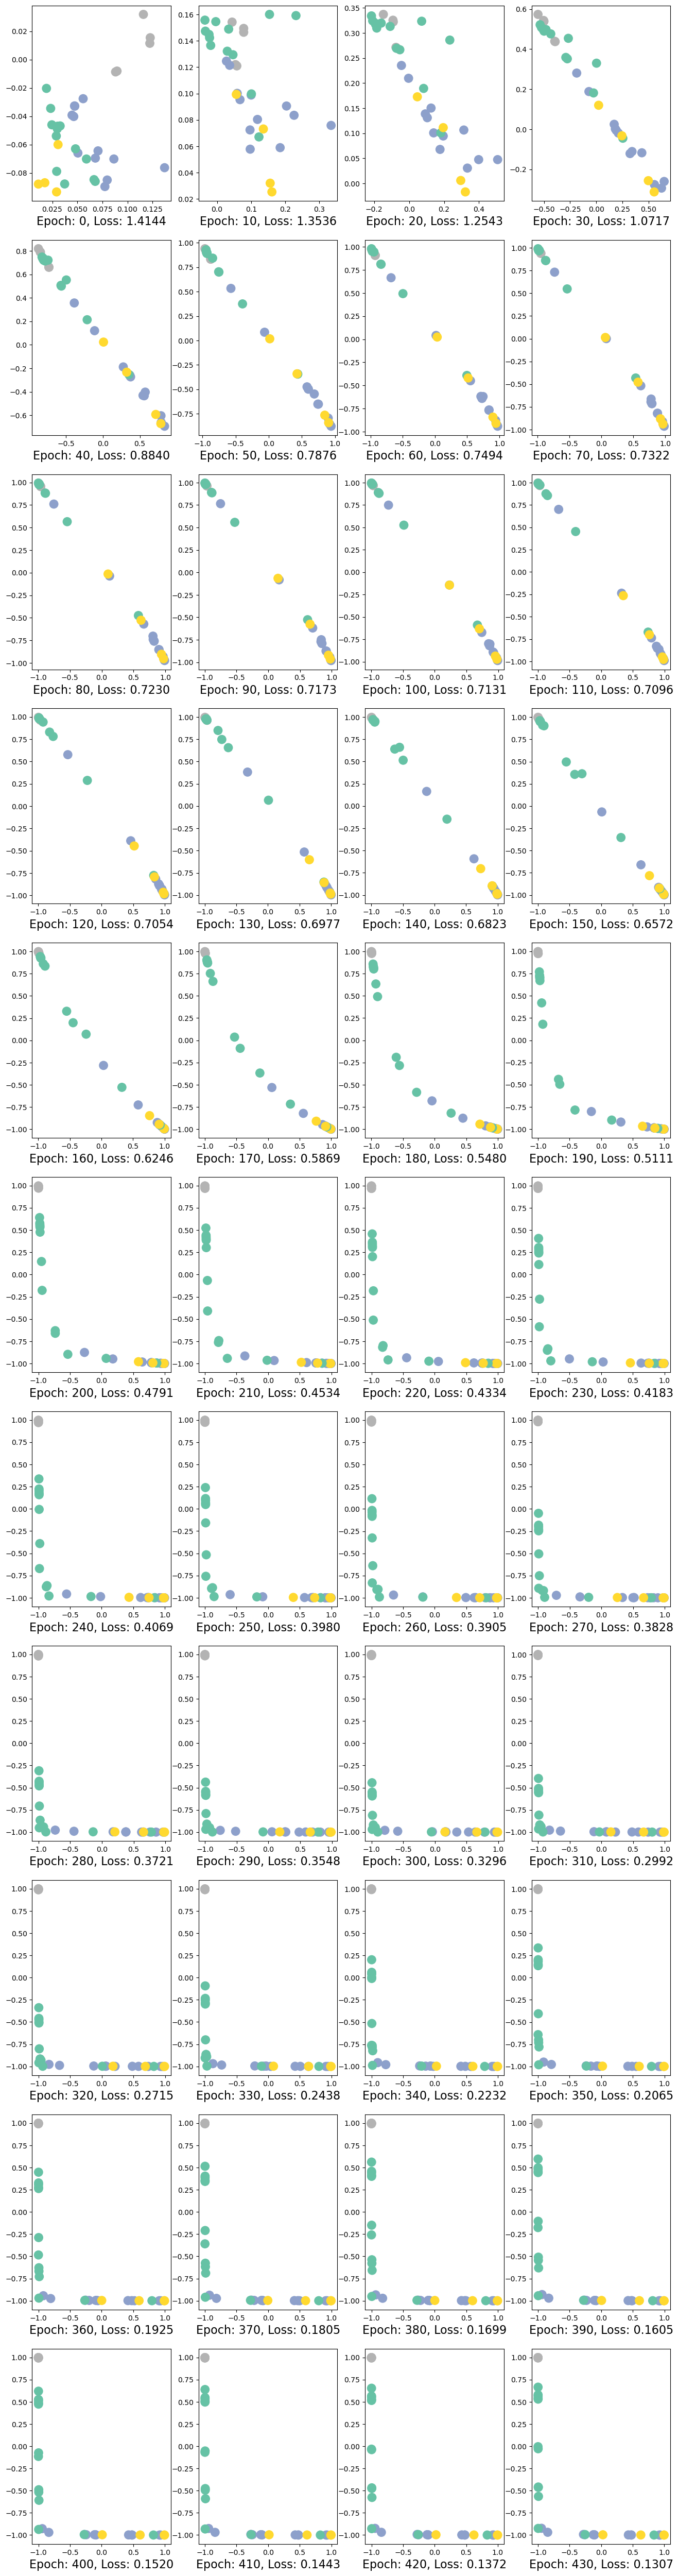

In [13]:
import time
from sklearn.metrics import f1_score, accuracy_score

fig, axes = plt.subplots(nrows=11, ncols=4, figsize=(16, 64))

def visualize(h, color, ax, epoch=None, loss=None):
    
#     ax.xticks([])
#     ax.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        ax.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            ax.set_xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                         node_color=color, cmap="Set2",)
    
    
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    # Compute the loss solely based on the training nodes.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(431):
    loss, h = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        num_col = (epoch // 10) % 4
        num_row = (epoch // 40)
        visualize(h, color=data.y, ax = axes[num_row][num_col], epoch=epoch, loss=loss)
        
        ### 정확도 추가
        out, h = model(data.x, data.edge_index)
        y_pred = torch.argmax(out[~data.train_mask], dim=1)
        y_pred = y_pred.detach().cpu().numpy()
        y_true = data.y[~data.train_mask].detach().cpu().numpy()
        f1 = f1_score(y_pred=y_pred, y_true=y_true, average='macro')
        acc = accuracy_score(y_pred=y_pred, y_true=y_true)
        print(f"epoch: {epoch}", end='\t')
        print(f"f1: {f1:.3f}", end='\t')
        print(f"acc: {acc:.3f}", end='\t')
        print()

## Refercences
---
- http://snap.stanford.edu/class/cs224w-2020/
- https://colab.research.google.com/drive/1CILdAekIkIh-AX2EXwZ3ZsZ6VcCbwc0t?usp=sharing